# systematics with the Asimov dataset

To assess the impact of various sources of systematic, we will rely on an Asimov dataset.

In [1]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'

from functools import partial
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import minimize
from tqdm.notebook import tqdm

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'figure.figsize': (8, 8),
          'axes.facecolor': 'white',
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline
%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 46259,
  "iopub_port": 60187,
  "stdin_port": 37273,
  "control_port": 38429,
  "hb_port": 46353,
  "ip": "127.0.0.1",
  "key": "ec1faa3b-d299c5d6104f57eba86d3036",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-2b97d8ba-73b2-4370-afb2-5fb2517a324e.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# configure, get the input data, and do any additional processing that is needed
processes = ['ttbar', 't', 'ww', 'wjets', 'zjets_alt', 'diboson', 'fakes'] 
selections = [
              'ee', 'mumu',
              'emu',
              'mutau', 'etau',
              'mu4j', 'e4j'
             ]

# initialize fit data
input_dir  = f'local_data/templates/test/'
fit_data   = fh.FitData(input_dir, selections, processes)
model_data = fit_data._model_data
parameters = fit_data._parameters

# get post fit uncertainties
parameters.loc[['br_tau_e', 'br_tau_mu', 'br_tau_h'], 'err_init'] *= parameters.loc[['br_tau_e', 'br_tau_mu', 'br_tau_h'], 'err_init']/100
#parameters.loc[['br_tau_e', 'br_tau_mu', 'br_tau_h'], 'err_fit'] *= parameters.loc[['br_tau_e', 'br_tau_mu', 'br_tau_h'], 'err_fit']/100
param_init = parameters['val_init'].values.copy()

In [3]:
# plot uncertainties
plot_labels = fh.fancy_labels
categories = list(model_data.keys())
summary_data = {pname:dict() for pname in parameters.index}
for category in tqdm(categories, leave=False):
    lep_category, jet_category = category.split('_', 1) 
    if jet_category not in pt.categories.keys():
        continue
        
    # get the data for the selection/category
    sdata = fit_data.get_selection_data(lep_category)
    bins = sdata[jet_category]['bins']
    template_nominal = fit_data.mixture_model(param_init, category)
    
    #print(category)
    #print(np.sqrt(template_nominal[0]))
    #print(1./np.sqrt(template_nominal[0].sum()))
    #
    #print(np.sqrt(template_nominal[1]))
    #print(np.sqrt(template_nominal[1].sum())/template_nominal[0].sum())
    #print('-----------')
    
    # loop over parameters to get varitations
    for ix, (pname, pdata) in tqdm(enumerate(parameters.iterrows()), 
                                   desc = category,
                                   leave=False, 
                                   total=parameters.shape[0]
                                  ):
        if not pdata[lep_category] or ix < 4:
            continue
            
        # prior uncertainties
        pval = param_init.copy()
        err_pre = pdata['err_init']
        pval[ix] = param_init[ix] + err_pre
        template_up = fit_data.mixture_model(pval, category)
        pval[ix] = param_init[ix] - err_pre
        template_down = fit_data.mixture_model(pval, category)
        var_pre_up = (template_up[0] - template_nominal[0])/template_nominal[0]
        var_pre_down = (template_down[0] - template_nominal[0])/template_nominal[0]
        
        # post-fit uncertainties
        err_post = pdata['err_init']
        pval[ix] = param_init[ix] + err_post
        template_up = fit_data.mixture_model(pval, category)
        pval[ix] = param_init[ix] - err_post
        template_down = fit_data.mixture_model(pval, category)
        
        var_post_up = (template_up[0] - template_nominal[0])/template_nominal[0]
        var_post_down = (template_down[0] - template_nominal[0])/template_nominal[0]
        
        # save up/down variations
        summary_data[pname][category] = (template_nominal[0].sum(), template_nominal[1].sum(), template_up[0].sum(), template_down[0].sum())
        
        #if pname == 'top_pt':
        #    var_pre_down = np.zeros(var_pre_down.size)
        #    var_post_down = np.zeros(var_post_down.size)
        
        # statistical uncertainties
        err_stat_mc = np.sqrt(template_nominal[1])/template_nominal[0]
        err_stat_data = 1./np.sqrt(template_nominal[0])
        
        # setting axis limits
        ymin = np.min([var_pre_up.min(), var_pre_down.min(), var_post_up.min(), var_post_down.min()])
        ymax = np.max([var_pre_up.max(), var_pre_down.max(), var_post_up.max(), var_post_down.max()])
        ylim = np.max(np.abs([ymin, ymax])) 
        
        # make the plots
        fig, ax = plt.subplots(1, 1, figsize=(14, 5), facecolor='white')
        x = bins[:-1]
        dx = bins[1:] - bins[:-1]
        ax.fill_between(x, -err_stat_mc, err_stat_mc, edgecolor='r', facecolor='none', step='post', hatch='\\', alpha=0.5, label=r'$\sigma_{stat. MC}$')
        ax.fill_between(x, -err_stat_data, err_stat_data, edgecolor='r', facecolor='none', step='post', hatch='/', alpha=0.5, label=r'$\sigma_{stat. data}$')
        
        ax.plot(x, var_pre_up, drawstyle='steps-post', c='C0', linestyle='--', linewidth=2., label=r'$\sigma_{\theta}$ (pre-fit)')
        ax.plot(x + dx/2, var_pre_up, c='C0', marker='^', markersize=8, linestyle='None', label='_nolegend_')
        ax.plot(x, var_pre_down, drawstyle='steps-post', c='C0', linestyle='--', linewidth=2., label='_nolegend_')
        ax.plot(x + dx/2, var_pre_down, c='C0', marker='v', markersize=8, linestyle='None', label='_nolegend_')
        
        #ax.plot(x, var_post_up, drawstyle='steps-post', c='C1', linestyle='--', linewidth=2., label=r'$\sigma_{\theta}$ (post-fit)')
        #ax.plot(x + dx/2, var_post_up, c='C1', marker='^', markersize=8, linestyle='None', label='_nolegend_')
        #ax.plot(x, var_post_down, drawstyle='steps-post', c='C1', linestyle='--', linewidth=2., label='_nolegend_')
        #ax.plot(x + dx/2, var_post_down, c='C1', marker='v', markersize=8, linestyle='None', label='_nolegend_')
        
        ax.set_xlabel(f'{plot_labels[lep_category][0]}', fontsize=20)
        ax.set_ylabel(r'$\frac{\delta N}{N}$')
        ax.set_xlim(x[0], x[-1])
        if ylim > 0.:
            ax.set_ylim(-1.25*ylim, 1.25*ylim)
        ax.set_title(pdata['label'], fontsize=24)
        ax.grid()
        
        txt = ax.text(0.2, 0.9, f'{plot_labels[lep_category][1]}, {pt.categories[jet_category].label}', 
                      horizontalalignment='center', 
                      verticalalignment='center', 
                      transform=ax.transAxes, 
                      fontsize=22
                     )
        txt.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='red'))
        
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
        plt.tight_layout(rect=[0, 0, 0.98, 0.96])
        
        #plt.tight_layout()
        outdir = f'plots/systematics/sources/{lep_category}/{jet_category}'
        pt.make_directory(outdir, clear=False)
        plt.savefig(f'{outdir}/{pname}.png')
        plt.close()
    

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


KeyError: 'cat_eq3_gt2'

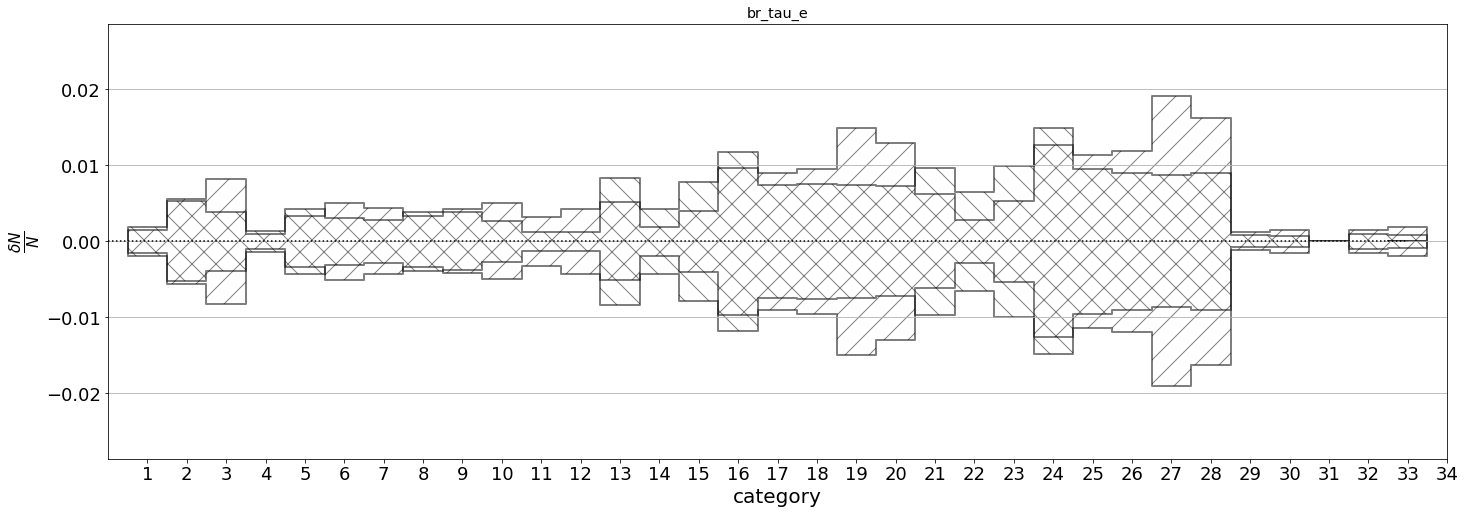

In [4]:
# category migration
format_dict = dict(ee=1, mumu=4, emu=7, mutau=13, etau=21, mu4j=29, e4j=31)

for pname, pdata in tqdm(summary_data.items(),  total=parameters.shape[0]):
    if 'beta' in pname:
        continue
    
    fig, ax = plt.subplots(1, 1, figsize=(24, 8), facecolor='white')
    y_nominal = np.array([pdata[cat][0] if cat in pdata.keys() else 0.for cat in categories])
    y_err = np.array([np.sqrt(pdata[cat][1]) if cat in pdata.keys() else 0.for cat in categories])
    y_up = np.array([pdata[cat][2] if cat in pdata.keys() else 0. for cat in categories])
    y_down = np.array([pdata[cat][3] if cat in pdata.keys() else 0. for cat in categories])
    
    #print(pname, y_err, np.sqrt(y_nominal), '---', sep='\n')
    
    x = np.arange(1, y_nominal.size+1, 1)
    nan_mask = y_nominal == 0
    d_up = (y_up - y_nominal)/y_nominal
    d_down = (y_down - y_nominal)/y_nominal
    d_up[nan_mask], d_down[nan_mask] = 0., 0.
    ax.bar(x, d_up, color='C0', alpha=0.75, label='up')
    ax.bar(x, d_down, color='C1', alpha=0.75, label='down')
    
    # MC stats
    x = np.append(x, 33)
    d_err_down, d_err_up = -y_err/y_nominal, y_err/y_nominal
    d_err_up[nan_mask], d_err_down[nan_mask] = 0., 0.
    d_err_down, d_err_up = np.append(d_err_down, d_err_down[-1]), np.append(d_err_up, d_err_up[-1])
    ax.fill_between(x-0.5, d_err_down, d_err_up, linewidth=2, edgecolor='k', facecolor='none', hatch='\\', step='post', alpha=0.5, label='MC stat.')
    
    # data stats
    d_err_down, d_err_up = -1/np.sqrt(y_nominal), 1/np.sqrt(y_nominal)
    d_err_up[nan_mask], d_err_down[nan_mask] = 0., 0.
    d_err_down, d_err_up = np.append(d_err_down, d_err_down[-1]), np.append(d_err_up, d_err_up[-1])
    ax.fill_between(x-0.5, d_err_down, d_err_up, linewidth=2, edgecolor='k', facecolor='none', hatch='/', step='post', alpha=0.5, label='Data stat.')
    
    ax.plot([0, 33], [0, 0], 'k:')
    ax.set_title(pname)
    ax.grid(axis='y')
    ax.set_xlim(0, 33)
    
    ymax, ymin = np.max([d_down.max(), d_up.max(), d_err_up.max()]), np.min([d_down.min(), d_up.min(), d_err_down.min()])
    ax.set_ylim(1.5*ymin, 1.5*ymax)
    
    ax.set_ylabel(r'$\frac{\delta N}{N}$', size=22)
    ax.set_xlabel('category')
    ax.set_xticks(x[:-1])
    xlabels = [pt.categories[cat.split('_', 1)[1]].label for cat in categories] 
    ax.set_xticklabels(xlabels)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
    
    for cat, xcoord in format_dict.items():
        ax.plot([xcoord-0.5, xcoord-0.5], [1.5*ymin, 1.5*ymax], 'r:')
        ax.text(0.015 + xcoord/33, 0.95, plot_labels[cat][1], 
                color='r',
                horizontalalignment='center', 
                verticalalignment='center', 
                transform=ax.transAxes, 
                fontsize=18
               )
    ax.plot([32.5, 32.5], [1.5*ymin, 1.5*ymax], 'r:')
        
    outdir = f'plots/systematics/sources/summary'
    pt.make_directory(outdir, clear=False)
    plt.tight_layout(rect=[0, 0, 0.98, 0.96])
    plt.savefig(f'{outdir}/{pname}_summary.png')
    plt.close()